In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt

In [0]:
N_NETWORKS = 100
BATCH_SIZE = 60
N_EPOCHS   = 30

In [0]:
DATA_PATH = 'home/'
MODEL_STORE_PATH = 'home/model_'
model_paths = []
for i in range(100):
    model_paths.append(MODEL_STORE_PATH + str(i) + '.pt')
    open(model_paths[i], "w")

In [0]:
#transform data to tensor and normalize (values state for MNIST!)
trans = tt.Compose([tt.ToTensor(), tt.Normalize((0.1307,), (0.3081,))]) 

train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True,  transform=trans, download=True) 
test_dataset  = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)
print(len(train_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(BATCH_SIZE, -1)

In [0]:
class FConvMNIST(nn.Module):
    def __init__(self, seq, clf):
        super(FConvMNIST, self).__init__()
        self.seq = seq
        self.clf = clf
        
    def forward(self, x):
        return self.clf(self.seq(x)) 

In [0]:
#architecture of the network copied from the article
seq = nn.Sequential(
    nn.Conv2d(1, 256, kernel_size=(7, 7), stride=(1, 1)),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1)),
    nn.LeakyReLU(negative_slope=0.01),
    nn.MaxPool2d(kernel_size=2,stride=2, padding=0, dilation=1, ceil_mode=False),
    Flatten()
)
clf = nn.Linear(in_features=4608, out_features=10, bias=True)

In [0]:
model = FConvMNIST(seq, clf)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [0]:
loss_list = []
acc_list  = []
N_STEPS = len(train_loader)
print(N_STEPS)

#train network
for i in range(N_NETWORKS):
    for j in range(N_EPOCHS):
        for k, (images, labels) in enumerate(train_loader):
            #forward
            pred = model(images)
            loss = criterion(pred, labels)
            loss_list.append(loss.item())
            
            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            #statictics
            total = labels.size(0)
            _, predicted = torch.max(pred.data, 1)
            
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if k % 100 == 0:
                print('Network {}/{} Epoch {}/{}, Step {}/{}, Loss: {}, Accuracy: {}%'
                      .format(i, N_NETWORKS, j, N_EPOCHS, k, N_STEPS, loss.item(),
                              (sum(acc_list) / len(acc_list)) * 100))
                
    torch.save(model.state_dict(), model_paths[i])
    close(model_paths[i], "w")
    model = FConvMNIST(seq, clf)
    

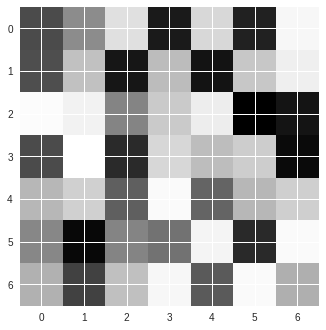

In [21]:
parameters = model.parameters()

#get 256 tensors with shape [1, 7, 7]
layer_weights = next(parameters)

#draw one weight
imgplot = plt.imshow(layer_weights[0].view(7, -1).data)